# **2D Segmentation Example**

In this notebook, we will train a 2D U-net for membrane boundary prediction in EM-Images of neural tissue. The U-net is the most common architecture for segmentation tasks in bio-medical imaging. It was introduced in https://arxiv.org/abs/1505.04597 and we will re-implement the ISBI challenge experiments in this notebook.

 It is still possible to do this exercise on the CPU, but you will need some patience to wait for the training. That's why we have added GPU support already in case you have access to a GPU.

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pickle 
os.chdir('drive/ESRF_Tutorial')

In [0]:
import os
import random
import pandas as pd
from itertools import chain
import numpy as np
# h5py to read the data-set
import h5py
# matplotlob for plotting
import matplotlib.pyplot as plt
# tensorboard
from keras.callbacks import TensorBoard

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


# Data pre-processing

First, we load the data-set. We are using data from the ISBI2012 neuron segmentation challenge (http://brainiac2.mit.edu/isbi_challenge/home).

For your convinience, we provide this data already as hdf5 volumes. You can download it with this link https://uabox.univ-angers.fr/index.php/s/7k7qWFUoyC45QR2.

Then, we pre-process the training data: we use reflection padding to increase the size of our input data and then normalize the input data to zero mean and unit variance.

In [0]:
# load the isbi data from file using h5py
# please adjust `path` s.t. it points to the location where you
# have stored the isbi data

path = 'isbi2012_train.h5'
# path = 'isbi2012_train.h5'
with h5py.File(path, 'r') as f:
    data = f['volumes/raw'][:]
    labels = f['volumes/labels/membranes'][:]

# we need to postprocess the labels. When we load them,
# they have value 0 for membranes and 255 for cell inside
print("Initial unique labels", np.unique(labels))
# map to [0, 1]
labels /= 255
# invert the labels to have membranes as foreground (value 1)
# and inside of the cell as background (value 0).
# this is necessary for the sorensen dice metric we will use later
labels = 1. - labels
print("Unique labels after processing", np.unique(labels))

assert data.shape == labels.shape
print("Loaded data and labels of shape", labels.shape)

Initial unique labels [  0. 255.]
Unique labels after processing [0. 1.]
Loaded data and labels of shape (30, 512, 512)


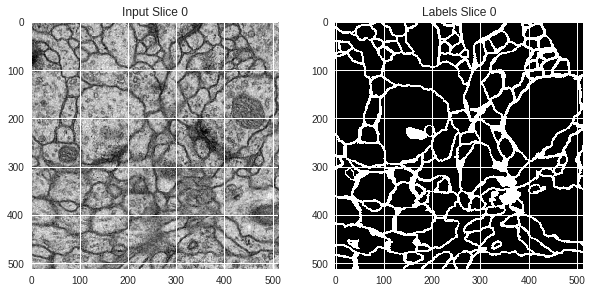

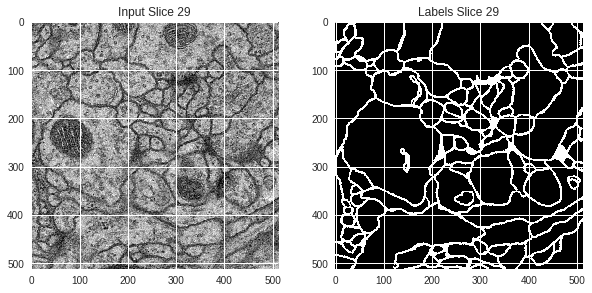

In [0]:
# first, we have a look at the data and the labels
def view_slice(slice_id):
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(221)
    plt.imshow(data[slice_id], cmap='gray')
    plt.title("Input Slice %i" % slice_id)
    plt.subplot(222)
    plt.imshow(labels[slice_id], cmap='gray')
    plt.title("Labels Slice %i" % slice_id)
    plt.show()

# view lower and upper slice
view_slice(0)
view_slice(29)

In [0]:
# as a next step, we normalize the data to
# have zero mean and unit variance.
# this is a common data-preprocessing step to
# ensure proper normalization of the network input data
data_mean = data.mean()
data_std = data.std()
print("The data mean value is", data_mean)
print("The data std value is", data_std)

data -= data_mean
data /= data_std
# check again to double check
print("After normalization the data has mean value", data.mean())
print("After normalization the data has standard deviation", data.std())

The data mean value is 0.49475786
The data std value is 0.17263508
After normalization the data has mean value -6.874247e-07
After normalization the data has standard deviation 1.0000002


In [0]:
# finally, split the data into train and validation data
# and make them ready for feeding to the network

# add a channel dimension
data_pad = data[:,:,:, None]
labels = labels[:,:,:, None]

# make train validation split
# we split the data along the z-axis to have 25 training images
# and 5 test images
split = 25
train_data, train_labels = data_pad[:split], labels[:split]
val_data, val_labels = data_pad[split:], labels[split:]
test_data, test_labels = data_pad[split:], labels[split:]
print("Shape of training data:", train_data.shape)
print("Shape of validation data", val_data.shape)
print("Shape of Testing data", test_data.shape)


Shape of training data: (25, 512, 512, 1)
Shape of validation data (5, 512, 512, 1)
Shape of Testing data (5, 512, 512, 1)


# U-net

The U-net has an encoder-decoder structure: 

In the encoder pass, the input image is successively downsampled via max-pooling. In the decoder pass it is upsampled again via transposed convolutions.

In adddition, it has skip connections, that bridge the output from an encoder to the corresponding decoder.

Note that we are using valid convolutions here; the input to convolutions are not padded and the spatial output size after applying them decreases. Hence, the spatial output size of the network will be smaller than the spatial input size. This could be avoided by using same convolutions, which would increase the computational effort though.

Compared to the paper, we will use less features (channels) to enable training the network on the CPU as well.

In [0]:
#Each block of u-net architecture consist of two Convolution layers
# These two layers are written in a function to make our code clean
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               padding="same")(x)
    x = Activation("relu")(x)
    return x

In [0]:
# The u-net architecture consists of contracting and expansive paths which
# shrink and expands the inout image respectivly. 
# Output image have the same size of input image
def get_unet(input_img, n_filters):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3) # last layer on encoding path 
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c5) #upsampling included
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*32, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*16, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*4, kernel_size=3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Training

We use Binary Cross Entropy averaged over pixels as training loss.
This loss function is similar to the cross entropy loss we have used
for the previous classification tasks.

The difference to these tasks is that we predict a single number per pixel
(the probability of this pixel being foreground / cell membrane) instead of 
a vector per image that encodes the probabilities for several classes.

Unlike the paper, we will use the Dice Coefficeint (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the network predictions.

The Dice Coefficient compares to sets $a$, $b$ and can be expressed as $$\frac{2 |a ~ b|}{a^2 + b^2}.$$
We can use it for validation if we interpret set $a$ as predictions and $b$ as labels.
It is often used to evaluate segmentations with sparse foreground, because the denominator normalizes by the number of foreground pixels.

The Dice Coefficient is closely related to Jaccard Index / Intersection over Union.

In [0]:
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

In [0]:
# Creating and Compiling the model
input_img = Input((data_pad.shape[1], data_pad.shape[2], 1), name='img')
model = get_unet(input_img, n_filters=4)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coefficient])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [0]:
# saving the log and show it by tensorboard
#NAME='u-net'
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://e499314f.ngrok.io


In [0]:
# Fiting the model 
results = model.fit(train_data, train_labels, 
                    batch_size=1, epochs=5, 
                    callbacks=[TensorBoardColabCallback(tbc)],
                    validation_data=(val_data, val_labels))

Train on 25 samples, validate on 5 samples
Epoch 1/5
25/25 [==============================] - 79s 3s/step - loss: 0.4902 - dice_coefficient: 0.5218 - val_loss: 0.3464 - val_dice_coefficient: 0.6079
Epoch 2/5
25/25 [==============================] - 77s 3s/step - loss: 0.3656 - dice_coefficient: 0.6442 - val_loss: 0.3311 - val_dice_coefficient: 0.6349
Epoch 3/5
25/25 [==============================] - 77s 3s/step - loss: 0.3683 - dice_coefficient: 0.6500 - val_loss: 0.3235 - val_dice_coefficient: 0.6448
Epoch 4/5
25/25 [==============================] - 77s 3s/step - loss: 0.3403 - dice_coefficient: 0.6719 - val_loss: 0.3002 - val_dice_coefficient: 0.6966
Epoch 5/5
25/25 [==============================] - 77s 3s/step - loss: 0.3149 - dice_coefficient: 0.7158 - val_loss: 0.3030 - val_dice_coefficient: 0.7376


In [0]:
preds_test = model.predict(test_data, verbose=1)
preds_test_t = (preds_test > 0.7).astype(np.uint8)

5/5 [==============================] - 3s 685ms/step


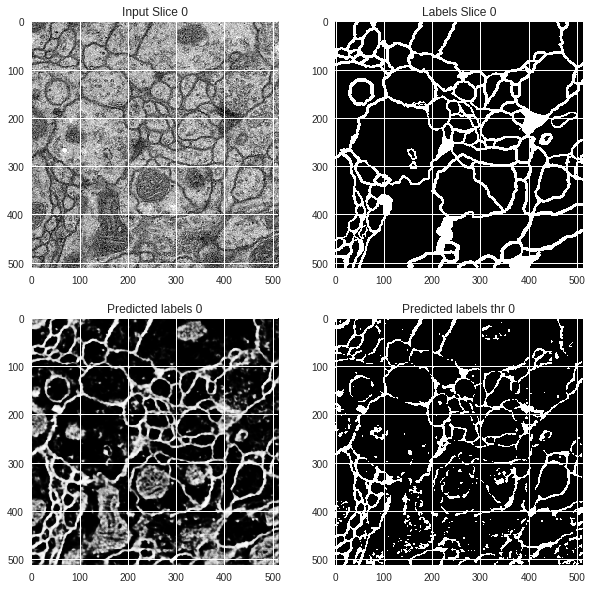

In [0]:
def view_slice(slice_id):
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(221)
    plt.imshow(test_data[slice_id,:,:,0], cmap='gray')
    plt.title("Input Slice %i" % slice_id)
    plt.subplot(222)
    plt.imshow(test_labels[slice_id,:,:,0], cmap='gray')
    plt.title("Labels Slice %i" % slice_id)
    plt.subplot(223)
    plt.imshow(preds_test[slice_id,:,:,0], cmap='gray')
    plt.title("Predicted labels %i" % slice_id)
    plt.subplot(224)
    plt.imshow(preds_test_t[slice_id,:,:,0], cmap='gray')
    plt.title("Predicted labels thr %i" % slice_id)
    plt.show()

# view lower and upper slice
view_slice(0)